## Image classification to differentiate a weed from a crop seedling. 

For more information: https://www.kaggle.com/c/plant-seedlings-classification

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

from fastai.plots import *


In [3]:
PATH = "data/seedling/"

In [6]:
from glob2 import glob
import pandas as pd

In [4]:
df = pd.DataFrame(columns=["file", "species"])

In [5]:
for image in glob(f"{PATH}train/**/*.png"):
    dir_=image.split('/')
    file_, species = dir_[-1], dir_[-2]
    
    df = df.append({
        "file":file_,
        "species": species.replace(' ', '_')
        }, ignore_index=True)
    df.to_csv('labels.csv', index=False)

In [ ]:
!ls {PATH}

In [ ]:
len(f'{PATH}test')

In [7]:
df = pd.read_csv(f'{PATH}labels.csv')

In [8]:
len(np.unique(df.species))

12

In [ ]:
np.unique(df.species)

In [9]:
df.describe()

,file,species
count,4750,4750
unique,4750,12
top,bf351fa53.png,Loose_Silky-bent
freq,1,654


In [ ]:
df.columns

In [ ]:
df.head()

In [ ]:
df.pivot_table(index='species', aggfunc=len).sort_values('file', ascending=False)

In [ ]:
np.unique(df['species'])

In [ ]:
!head '{PATH}labels.csv'

In [ ]:
#fn= PATH+train.df.fnames[45]; fn

### Validation Set

In [10]:
label_csv = f'{PATH}labels.csv'
len(list(open(label_csv)))

4751

In [11]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [12]:
val_idxs.shape, n

((950,), 4750)

In [ ]:
!wc -l '{PATH}labels.csv'

# Model

In [13]:
arch=resnet50
bs=64
sz=224

In [14]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)

In [15]:
data = ImageClassifierData.from_csv(PATH,'train', csv_fname=f'{PATH}labels.csv', test_name='test',
                                   val_idxs=val_idxs, tfms=tfms, bs=bs)

In [16]:
data.test_dl.dataset.n

794

In [17]:
data.test_aug_dl.dataset.n

794

In [20]:
len(data.classes)

12

In [ ]:
from sklearn import metrics

In [21]:
learn=ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


In [ ]:
#learn=ConvLearner.pretrained(arch, data)

In [22]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 77%|███████▋  | 46/60 [00:02<00:00, 22.85it/s, loss=13.9]


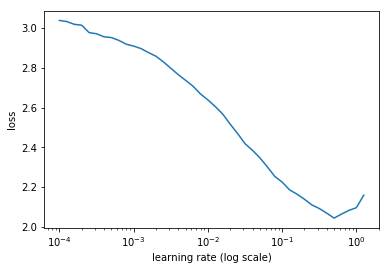

In [23]:
learn.sched.plot()

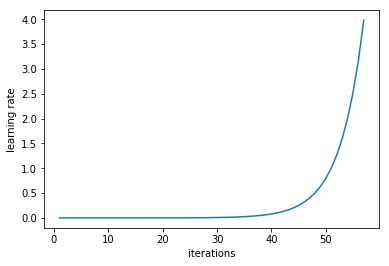

In [24]:
learn.sched.plot_lr()

In [25]:
learn.fit(1e-2, 5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       1.20247  0.6428   0.78897]                     
[ 1.       0.75638  0.49919  0.82847]                      
[ 2.       0.55572  0.43105  0.84826]                      
[ 3.       0.43506  0.40105  0.86408]                      
[ 4.       0.37453  0.38928  0.85556]                      



## Training all Layers and using Data Augmentation

In [26]:
learn.precompute=False

In [27]:
learn.fit(1e-2, 5, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       0.51771  0.39131  0.87365]                      
[ 1.       0.50053  0.35773  0.87593]                      
[ 2.       0.48194  0.35398  0.8799 ]                      
[ 3.       0.46651  0.33193  0.87782]                      
[ 4.       0.44133  0.33585  0.88426]                      



In [28]:
learn.save('224_pre')

In [ ]:
learn.load('224_pre')

In [29]:
learn.unfreeze()

In [30]:
lr=np.array([1e-4,1e-3,1e-2])

In [31]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.50809  0.33     0.88225]                      
[ 1.       0.34738  0.20235  0.93029]                      
[ 2.       0.25012  0.19351  0.92176]                      
[ 3.       0.21391  0.18077  0.93777]                      
[ 4.       0.17386  0.15741  0.9409 ]                      
[ 5.       0.14625  0.14265  0.95274]                      
[ 6.       0.13497  0.14316  0.95293]                      



In [32]:
learn.save('224_final')

In [33]:
learn.load('224_final')

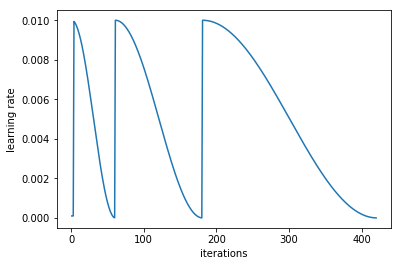

In [34]:
learn.sched.plot_lr()

In [35]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)

In [36]:
accuracy(preds, y)

0.96210526315789469

In [39]:
sz=299

In [40]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, folder='train', csv_fname=f'{PATH}labels.csv', test_name='test',
                                   val_idxs=val_idxs, tfms=tfms, bs=bs)

In [41]:
learn.freeze()
learn.bn_freeze(True)

In [42]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 85%|████████▌ | 51/60 [00:35<00:06,  1.44it/s, loss=0.47] 

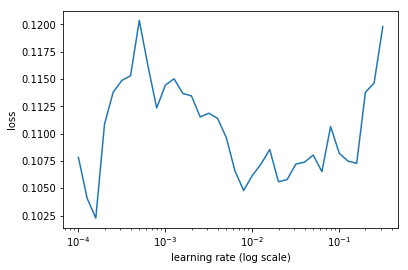

In [43]:
learn.sched.plot()

In [44]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  2%|▏         | 1/60 [00:02<02:54,  2.95s/it, loss=0.156]

Exception in thread Thread-30:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[ 0.       0.10537  0.14362  0.9517 ]                       
[ 1.       0.1027   0.14428  0.95151]                       
[ 2.       0.10125  0.14284  0.95606]                       
[ 3.       0.10316  0.13804  0.95066]                       
[ 4.       0.09138  0.13773  0.95606]                       
[ 5.       0.10014  0.13442  0.9571 ]                       
[ 6.       0.09223  0.13396  0.95606]                       



In [45]:
learn.unfreeze()

In [46]:
learn.fit(lr, 3, cycle_len=2, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

[ 0.       0.1904   0.16909  0.94128]                       
[ 1.       0.13185  0.13519  0.95066]                      
[ 2.       0.15454  0.19508  0.93198]                      
[ 3.       0.14078  0.16717  0.93939]                      
[ 4.       0.10465  0.11108  0.9588 ]                      
[ 5.       0.07125  0.11165  0.96316]                       
[ 6.       0.10572  0.18749  0.93086]                       
[ 7.       0.12262  0.17803  0.94213]                      
[ 8.       0.11086  0.12887  0.9517 ]                      
[ 9.       0.08678  0.1223   0.96316]                       
[ 10.        0.06234   0.10074   0.9625 ]                   
[ 11.        0.04542   0.09266   0.96667]                   
[ 12.        0.03702   0.09907   0.96771]                   
[ 13.        0.03413   0.0973    0.96771]                   



In [47]:
learn.save('299_pre')

In [48]:
learn.freeze()
learn.bn_freeze(True)

In [49]:
learn.fit(1e-2, 3, cycle_mult=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.02821  0.09624  0.96979]                       
[ 1.       0.03253  0.09841  0.97083]                       
[ 2.       0.03125  0.10331  0.96667]                       



In [50]:
learn.save('299_final')

In [51]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)

In [52]:
preds.shape

(950, 12)

In [53]:
accuracy(preds, y)

0.97894736842105268

In [63]:
test_log_preds, y = learn.TTA(is_test=True)
test_probs = np.mean(np.exp(test_log_preds),0)
test_probs.shape

(794, 12)

In [64]:
preds_test = np.argmax(test_probs, axis=1)

In [65]:
preds_classes = [data.classes[i].replace("_", " ") for i in preds_test]

In [66]:
len(preds_classes)

794

In [68]:
len(np.unique(os.listdir(f'{PATH}test')))

794

In [69]:
submission=pd.DataFrame({'file': os.listdir(f'{PATH}test'), 'species': preds_classes})

In [ ]:
test=pd.DataFrame({'file': os.listdir(f'{PATH}test')})

In [72]:
submission.describe()

,file,species
count,794,794
unique,794,12
top,ae90f2827.png,Loose Silky-bent
freq,1,116


In [70]:
submission.head()

,file,species
0,12625488b.png,Fat Hen
1,c832e4302.png,Fat Hen
2,e82017baa.png,Loose Silky-bent
3,c10ccbd82.png,Scentless Mayweed
4,8b27bfd2b.png,Small-flowered Cranesbill
